In [1]:
import pandas as pd
import numpy as np
import scipy.special 
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from tabulate import tabulate

In [2]:
# Set save_figures to True, to save graphs as .svg files
save_figures = True
def save_svg(filename):
    if save_figures:
        plt.savefig("./figs/" + filename + ".svg")

In [3]:
mpl.style.use("seaborn")
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)
mpl.rc('axes', labelsize=20)
mpl.rc('legend', fontsize=14)

 # TZ metrics

## Static route stretch

In [5]:
def import_stretch(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"], usecols=[0,1,2])
    return df

In [6]:
def crunch_stretch(filename):
    pandas_data = import_stretch(filename)
    static_stretch = pandas_data.to_numpy()
    
    # Filter out paths with same origin and destination
    static_stretch = static_stretch[static_stretch[:,0] > 0,:]
    
    # Filter out <1 stretch paths
    tz_better = static_stretch[static_stretch[:,0] > static_stretch[:,1], :]
    bgp_better = static_stretch[static_stretch[:,0] <= static_stretch[:,1], :]
    
    plt.plot([1, 14], [1, 14], alpha=.5, color="xkcd:slate", zorder=1)
    plt.scatter(bgp_better[:,0], bgp_better[:,1], alpha=.05, label="BGP as reference", zorder=2)
    plt.scatter(tz_better[:,0], tz_better[:,1], alpha=.05, label="TZ as reference", zorder=2)
    plt.xlabel("BGP path length")
    plt.ylabel("TZ path length")
    plt.title("Path lenghts combinations")
    plt.legend()
    
    stretches = static_stretch[:,1].astype(float) / static_stretch[:,0] 
    stretch_distr = np.sort(stretches)
    
    bgp_better_stretch = bgp_better[:,1].astype(float) / bgp_better[:,0]
    
    print("Measured average stretch: %f\tMeasured median stretch: %f\t Paths with valleys: %f\n" % (np.average(stretches), np.median(stretches), np.average(static_stretch[:,2])))
    print("Average stretch (BGP ref): %f\tMedian stretch (BGP ref): %f\t Paths with valleys (BGP ref): %f\n" % (np.average(bgp_better_stretch), np.median(bgp_better_stretch), np.average(bgp_better[:,2])))
    
    stretch_distr = np.array([[x[0], x.shape[0]] for x in np.split(stretch_distr, np.unique(stretch_distr, return_index=True)[1])[1:]])
    stretch_distr[:,1] = stretch_distr[:,1] / float(static_stretch.shape[0])
    
    plt.figure()
    plt.xlabel("TZ stretch")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(stretch_distr[:,0], stretch_distr[:,1], '--o', alpha=.7, label="Stretch PDF")
    plt.plot(stretch_distr[:,0], np.cumsum(stretch_distr[:,1]), ':^', label="Stretch CDF")
    #plt.vlines(1.1, ymin=0, ymax=1, linestyles='dashed', colors=['green'])
    plt.legend()
    
    return stretch_distr

In [7]:
def crunch_stretch_with_valleys(filename):
    pandas_data = import_stretch(filename)
    static_stretch = pandas_data.to_numpy()
    
    # Filter out paths with same origin and destination
    static_stretch = static_stretch[static_stretch[:,0] > 0,:]
    
    with_valley_num = (static_stretch[:,2] == 1).sum()
    
    # Filter out paths that without valleys
    static_stretch = static_stretch[static_stretch[:,2] == 1,:]
    
    # Filter out <1 stretch paths
    tz_better = static_stretch[static_stretch[:,0] > static_stretch[:,1], :]
    bgp_better = static_stretch[static_stretch[:,0] <= static_stretch[:,1], :]
    
    plt.plot([1, 14], [1, 14], alpha=.5, color="xkcd:slate", zorder=1)
    plt.scatter(bgp_better[:,0], bgp_better[:,1], alpha=.05, label="BGP as reference", zorder=2)
    plt.scatter(tz_better[:,0], tz_better[:,1], alpha=.05, label="TZ as reference", zorder=2)
    plt.xlabel("BGP path length")
    plt.ylabel("TZ path length")
    plt.title("Path (with valleys) lenghts combinations")
    plt.legend()
    
    stretches = static_stretch[:,1].astype(float) / static_stretch[:,0] 
    stretch_distr = np.sort(stretches)
    
    bgp_better_stretch = bgp_better[:,1].astype(float) / bgp_better[:,0]
    
    print("Measured average stretch: %f\tMeasured median stretch: %f\t Paths with valleys: %f\n" % (np.average(stretches), np.median(stretches), np.average(static_stretch[:,2])))
    print("Average stretch (BGP ref): %f\tMedian stretch (BGP ref): %f\t Paths with valleys (BGP ref): %f\n" % (np.average(bgp_better_stretch), np.median(bgp_better_stretch), np.average(bgp_better[:,2])))
    
    stretch_distr = np.array([[x[0], x.shape[0]] for x in np.split(stretch_distr, np.unique(stretch_distr, return_index=True)[1])[1:]])
    stretch_distr[:,1] = stretch_distr[:,1] / float(static_stretch.shape[0])
    
    plt.figure()
    plt.xlabel("TZ stretch (paths with valleys)")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(stretch_distr[:,0], stretch_distr[:,1], '--o', alpha=.7, label="Stretch PDF")
    plt.plot(stretch_distr[:,0], np.cumsum(stretch_distr[:,1]), ':^', label="Stretch CDF")
    #plt.vlines(1.1, ymin=0, ymax=1, linestyles='dashed', colors=['green'])
    plt.legend()
    
    return stretch_distr, with_valley_num

### < 1 stretch study

In [7]:
spo_GRP_4000 = pd.read_csv("./simulation/data/full-stretch-spo-GRP-4000.csv", names=["baseline_stretch", "audited_stretch", "respects_no_valley", "baseline_nodes", "baseline_types", "audited_nodes", "audited_types"])

In [8]:
spo_GRP_4000.loc[3733]

baseline_stretch                                                     12
audited_stretch                                                       3
respects_no_valley                                                    0
baseline_nodes        29827>209>4637>4657>18106>134809>4788>7473>747...
baseline_types                      1>-1>-1>-1>-1>-1>-1>-1>-1>-1>-1>-1>
audited_nodes                                     29827>209>1299>61170>
audited_types                                                   1>0>-1>
Name: 3733, dtype: object

In [9]:
spo_GRP_4000.loc[3733]

baseline_stretch                                                     12
audited_stretch                                                       3
respects_no_valley                                                    0
baseline_nodes        29827>209>4637>4657>18106>134809>4788>7473>747...
baseline_types                      1>-1>-1>-1>-1>-1>-1>-1>-1>-1>-1>-1>
audited_nodes                                     29827>209>1299>61170>
audited_types                                                   1>0>-1>
Name: 3733, dtype: object

In [10]:
print("Baseline: \t%s" % np.array(spo_GRP_4000.loc[3733]["baseline_types"].split(">")[:-1]).astype(int))
print("Audited: \t%s" % np.array(spo_GRP_4000.loc[3733]["audited_types"].split(">")[:-1]).astype(int))

Baseline: 	[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Audited: 	[ 1  0 -1]


### Stretch overview

Measured average stretch: 1.173904	Measured median stretch: 1.166667	 Paths with valleys: 0.289793

Average stretch (BGP ref): 1.275584	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 0.311375



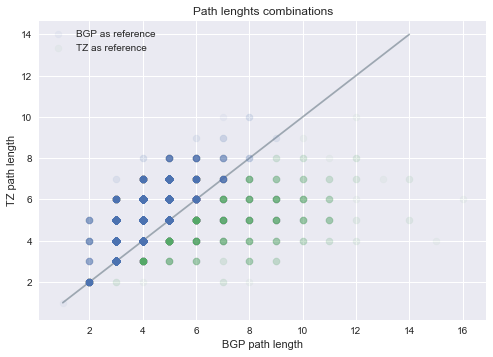

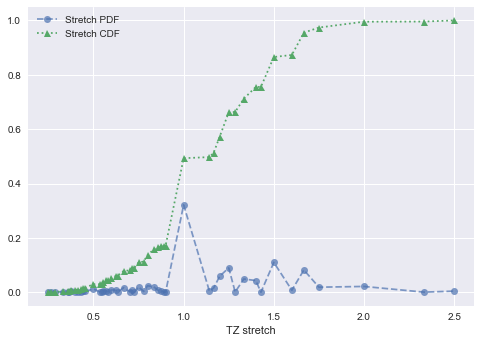

In [11]:
stretch_0_spo_GRP_4000 = crunch_stretch("./simulation/data/full-stretch-0-spo-GRP-4000.csv")

Measured average stretch: 1.063385	Measured median stretch: 1.000000	 Paths with valleys: 0.011657

Average stretch (BGP ref): 1.175066	Median stretch (BGP ref): 1.200000	 Paths with valleys (BGP ref): 0.013055



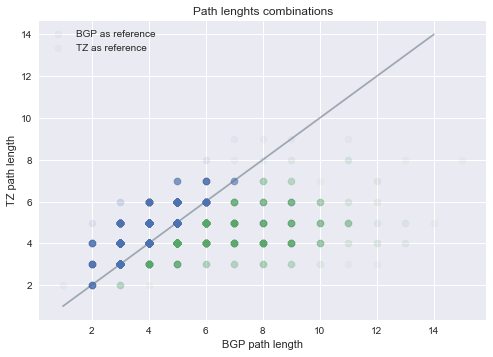

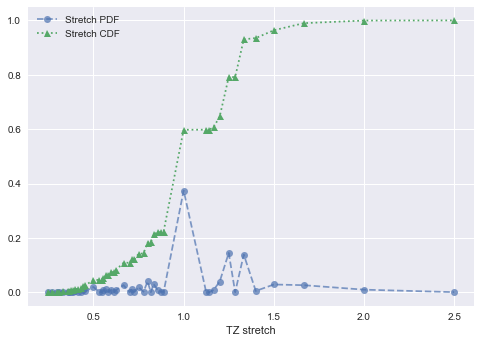

In [12]:
stretch_spo_GRP_4000 = crunch_stretch("./simulation/data/full-stretch-spo-GRP-4000.csv")

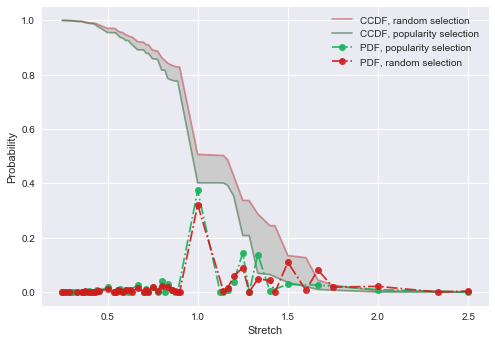

In [13]:
# Stretch comparison graph depending on landmark selection strategy
plt.plot(stretch_0_spo_GRP_4000[:,0], 1-np.cumsum(stretch_0_spo_GRP_4000[:,1]), '-', color="#c45054", alpha=.6, label="CCDF, random selection")
plt.plot(stretch_spo_GRP_4000[:,0], 1-np.cumsum(stretch_spo_GRP_4000[:,1]), '-', color="#41734d", alpha=.6, label="CCDF, popularity selection")
plt.plot(stretch_spo_GRP_4000[:,0], stretch_spo_GRP_4000[:,1], 'o-.', color="#14b359", alpha=.9, label="PDF, popularity selection")
plt.plot(stretch_0_spo_GRP_4000[:,0], stretch_0_spo_GRP_4000[:,1], 'o-.', color="#d11b1b", alpha=.9, label="PDF, random selection")
plt.fill(
    np.append(stretch_spo_GRP_4000[:,0], stretch_0_spo_GRP_4000[:,0][::-1]),
    np.append(1-np.cumsum(stretch_spo_GRP_4000[:,1]), (1-np.cumsum(stretch_0_spo_GRP_4000[:,1]))[::-1]),
    "#cccccc"
)
plt.xlabel("Stretch")
plt.ylabel("Probability")
plt.legend();
save_svg("ladmark-selection-stretch")

Measured average stretch: 1.054610	Measured median stretch: 1.000000	 Paths with valleys: 0.010106

Average stretch (BGP ref): 1.162861	Median stretch (BGP ref): 1.000000	 Paths with valleys (BGP ref): 0.009788



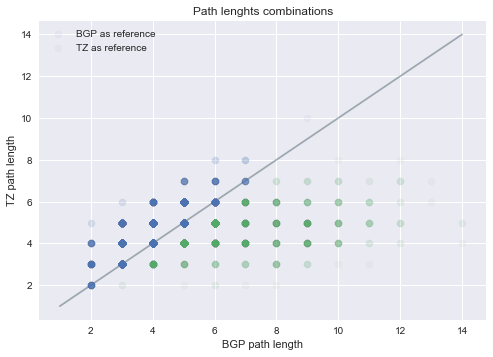

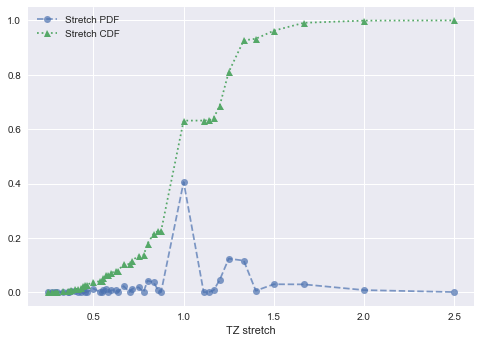

In [15]:
crunch_stretch("./simulation/data/full-stretch-GRP-4000.csv");

Measured average stretch: 1.101602	Measured median stretch: 1.000000	 Paths with valleys: 0.045827

Average stretch (BGP ref): 1.201329	Median stretch (BGP ref): 1.200000	 Paths with valleys (BGP ref): 0.049661



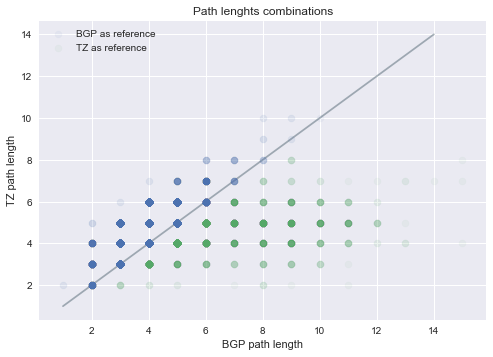

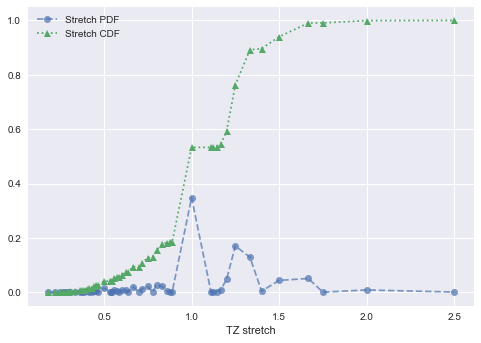

In [19]:
crunch_stretch("./simulation/data/full-stretch-GR-6000.csv");

Measured average stretch: 1.100412	Measured median stretch: 1.000000	 Paths with valleys: 0.015049

Average stretch (BGP ref): 1.204076	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 0.016460



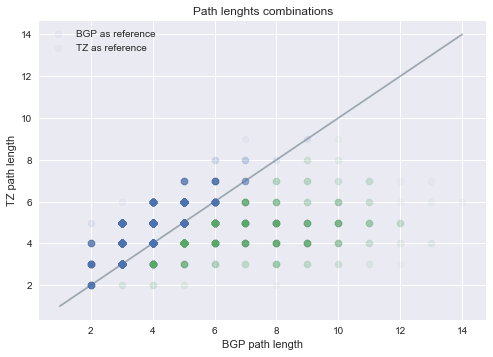

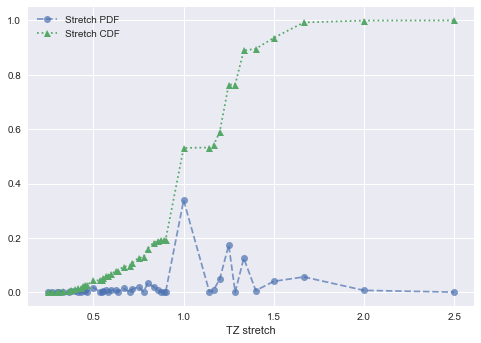

In [18]:
crunch_stretch("./simulation/data/full-GR-stretch-4000.csv");

Measured average stretch: 1.117611	Measured median stretch: 1.000000	 Paths with valleys: 0.150189

Average stretch (BGP ref): 1.227246	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 0.157254



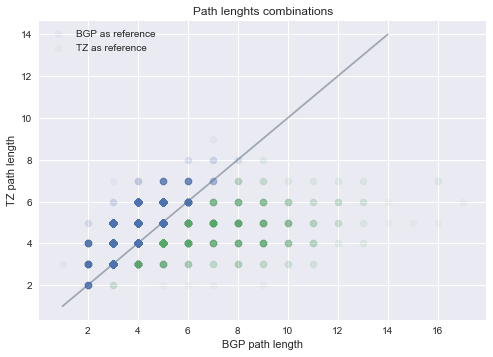

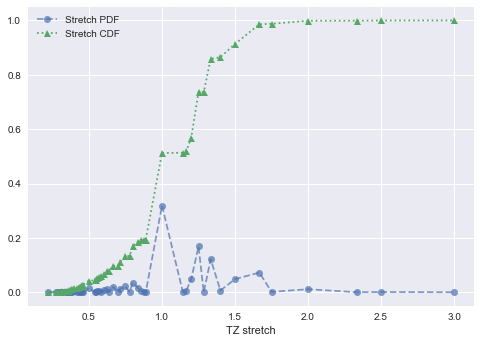

In [20]:
crunch_stretch("./simulation/data/full-GR(not-on-discovery)-stretch-4000.csv");

Measured average stretch: 1.105795	Measured median stretch: 1.000000	 Paths with valleys: 0.115520

Average stretch (BGP ref): 1.217322	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 0.119674



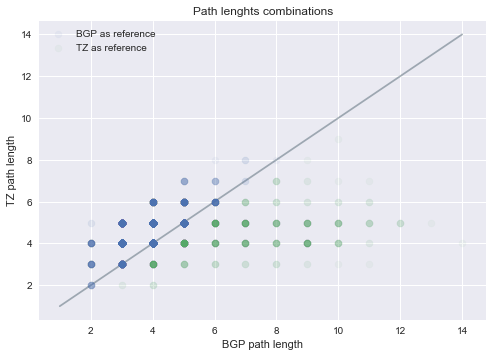

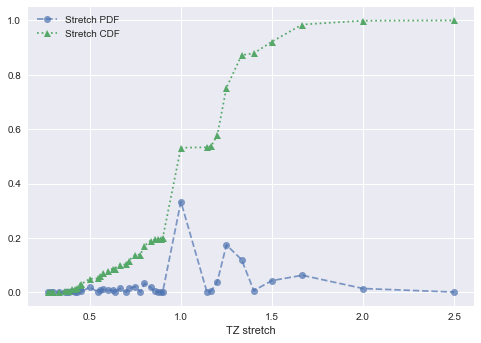

In [21]:
crunch_stretch("./simulation/data/full-stretch-2000.csv");

Measured average stretch: 1.360481	Measured median stretch: 1.400000	 Paths with valleys: 1.000000

Average stretch (BGP ref): 1.440003	Median stretch (BGP ref): 1.500000	 Paths with valleys (BGP ref): 1.000000



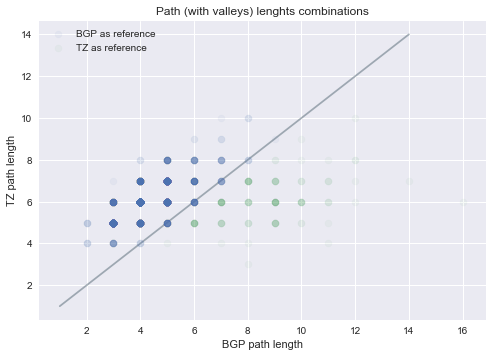

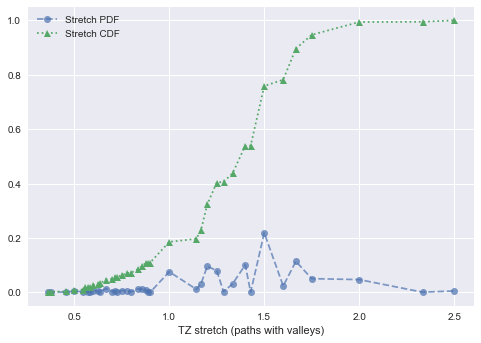

In [22]:
stretch_0_with_valleys, num_0_with_valleys = crunch_stretch_with_valleys("./simulation/data/full-stretch-0-spo-GRP-4000.csv")

Measured average stretch: 1.161706	Measured median stretch: 1.200000	 Paths with valleys: 1.000000

Average stretch (BGP ref): 1.250972	Median stretch (BGP ref): 1.250000	 Paths with valleys (BGP ref): 1.000000



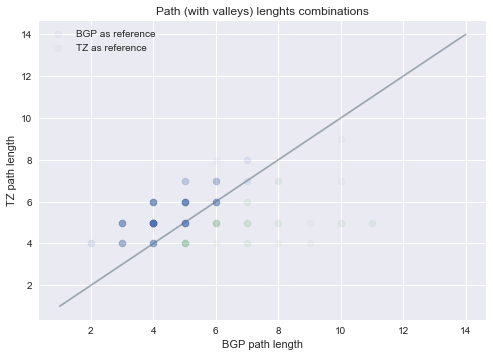

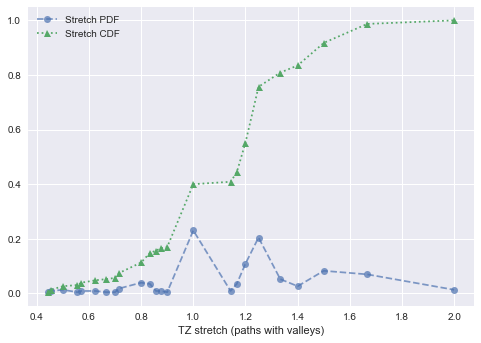

In [23]:
stretch_with_valleys, num_with_valleys = crunch_stretch_with_valleys("./simulation/data/full-stretch-2000.csv")

In [24]:
def group_stretch_by_unit(stretch_distr):
    max_stretch = int(stretch_distr[:,0].max()) + 1
    stretch_by_unit = []
    prev_mask = np.repeat(False, stretch_distr.shape[0])
    for i in range(0, max_stretch):
        curr_mask = (stretch_distr[:,0] - i) < 1
        stretch_by_unit.append(stretch_distr[np.logical_and(curr_mask,np.invert(prev_mask)),1].sum())
        prev_mask = curr_mask
        
    return max_stretch, np.array(stretch_by_unit)

In [25]:
cond_valleys = group_stretch_by_unit(stretch_with_valleys)
cond_0_valleys = group_stretch_by_unit(stretch_0_with_valleys)

In [26]:
cond_0_valleys[0], num_0_with_valleys

(3, 1147)

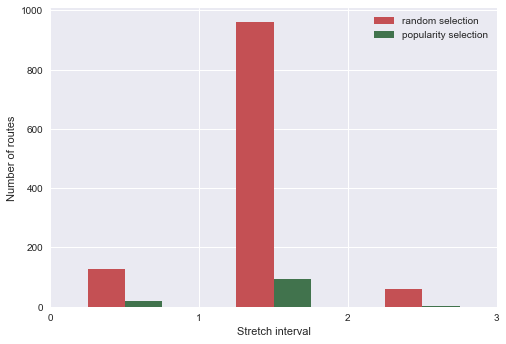

In [27]:
plt.bar(np.arange(cond_0_valleys[0]), cond_0_valleys[1] * num_0_with_valleys, width=.25, color="#c45054", label="random selection")
plt.bar(np.arange(cond_valleys[0])+.25, cond_valleys[1] * num_with_valleys * 2/4, width=.25, color="#41734d", label="popularity selection")
plt.gca().set_xticks(np.arange(max(cond_valleys[0], cond_0_valleys[0])+1)-.375)
plt.gca().set_xticklabels(np.arange(max(cond_valleys[0], cond_0_valleys[0])+1))
plt.xlabel("Stretch interval")
plt.ylabel("Number of routes")
plt.legend()
save_svg("stretch_with_valley")

## Link deletion impact

#### Load endpoints degree distribution

array([1. , 1.5, 2.5])

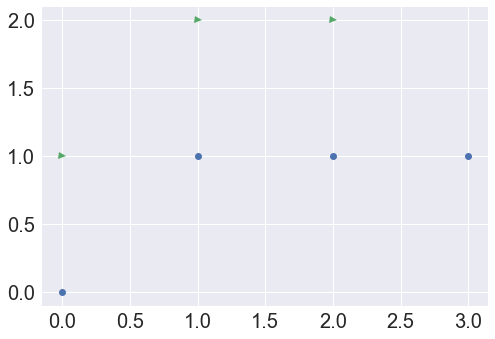

In [36]:
conv_data = np.array([1, 2, 3])
conv_part = np.convolve(conv_data, np.array([1, 1]), "full").astype(float)[:conv_data.shape[0]]
plt.plot(np.concatenate([np.repeat(0,2-1), np.repeat(1, conv_data.shape[0])]), "o")
conv_step = np.convolve(np.concatenate([np.repeat(0,2-1), np.repeat(1, conv_data.shape[0])]), np.array([1,1]), "valid").astype(float)
plt.plot(conv_step, ">")
conv_part = conv_part / conv_step
conv_part

In [37]:
def moving_average(data_param, window_size):
    window = np.repeat(1.0, window_size) / window_size
    return np.convolve(data_param, window, "full")[:data_param.shape[0]]

In [38]:
endpt_degree_pandas = pd.read_csv("./simulation/data/full-endpoints-degrees.csv")
endpt_degree = endpt_degree_pandas.to_numpy()

In [39]:
endpt_degree

array([[   1, 1151],
       [  11, 8237],
       [  11, 1264],
       ...,
       [   3,    8],
       [   3,    1],
       [   3,    1]], dtype=int64)

In [40]:
endpt_degree_distr = np.unique(np.around(np.maximum(endpt_degree[:,0], endpt_degree[:,1]) / np.minimum(endpt_degree[:,0], endpt_degree[:,1])), return_counts=True)

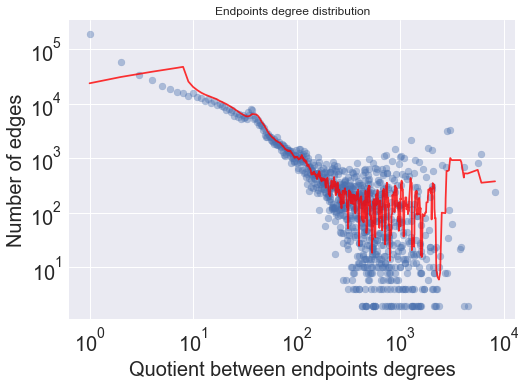

In [41]:
plt.scatter(endpt_degree_distr[0], endpt_degree_distr[1], alpha=.4)
plt.plot(endpt_degree_distr[0], moving_average(endpt_degree_distr[1], 8), "red", alpha=.8)
plt.title("Endpoints degree distribution")
plt.xlabel("Quotient between endpoints degrees")
plt.ylabel("Number of edges")
plt.yscale("log")
plt.xscale("log")

#### Load impact file

An impact file contains the following columns
  - `endpoint1` The asn of the first node
  - `endpoint2` The asn of the second node
  - `degree1` The number of links (before deletion) of the 1st node
  - `degree2` The number of links (before deletion) of the 2nd node
  - `impact` The number of nodes that must send/receive updates

In [26]:
def import_impact(filename):
    df = pd.read_csv(filename, names=["endpoint1", "endpoint2", "degree1", "degree2", "impact"], usecols=range(0,5))
    return df

In [27]:
def import_impact_measurements(filename):
    df = pd.read_csv(filename, names=["measure"], usecols=[5])
    return df

In [28]:
# Save impact to file
# link_del_impact.to_csv("./simulation/data/full-impact-2000.csv", index=False, header=False)

#### Impact by degree quotient
Here, I relate the number of updated nodes with the quotient between the maximum and the minimum degree of the endpoints  

In [29]:
def crunch_deletion_impact(filename):
    link_del_impact = import_impact(filename)
    deletion_impact = link_del_impact.to_numpy()
    print(link_del_impact)
    print("Average impact: %.3f \t Median impact: %.3f \t Maximum impact: %.0f \t Standard deviation: %.3f" % (deletion_impact[:,4].mean(), np.median(deletion_impact[:,4]), deletion_impact[:,4].max(), deletion_impact[:,4].std()))
    
    abs_deg_val = np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4])
    degree_quotient_impact = np.concatenate([np.maximum(deletion_impact[:,2:3], deletion_impact[:,3:4])/np.minimum(deletion_impact[:,2:3], deletion_impact[:,3:4]).astype(float), deletion_impact[:,4:5]], axis=1)
    
    # Handle appropriately deletions without updates (y=0)
    zero_impact_quotient_idxs = degree_quotient_impact[:,1] == 0.
    zero_impact_fraction = zero_impact_quotient_idxs.sum() / float(degree_quotient_impact.shape[0])
    zero_impact_deletions = degree_quotient_impact[zero_impact_quotient_idxs, :]
    zero_impact_deletions[:,1] = 1
    degree_quotient_impact = degree_quotient_impact[degree_quotient_impact[:,1] != 0., :]
        
    if zero_impact_quotient_idxs.sum() > 0:
        print("%.2f%% of the link deletions didn't require any update" % (zero_impact_fraction*100))
        print("Average degree quotient of zero-impact deletions:\t %.3f" % (zero_impact_deletions[:,0].mean()))
        zero_impact_idxs = deletion_impact[:,4] == 0.
        print("Average maximum degree of zero-impact deletions:\t %.3f" % (np.maximum(deletion_impact[zero_impact_idxs, 2], deletion_impact[zero_impact_idxs, 3]).mean()))
        print("Average minimum degree of zero-impact deletions:\t %.3f" % (np.minimum(deletion_impact[zero_impact_idxs, 2], deletion_impact[zero_impact_idxs, 3]).mean()))
    
    
    #▼plt.figure(figsize=(8, 6))
    #plt.title("Nodes updated by degree quotient")
    #plt.scatter(zero_impact_deletions[:,0], zero_impact_deletions[:,1], 60, marker='X', alpha=.1, zorder=10, label="Zero impact")
    plt.scatter(degree_quotient_impact[:,0], degree_quotient_impact[:,1], abs_deg_val * .004, color="#007BB088", label=r"radius = $\max(\deg(e_1), \deg(e_2))$")
    plt.yscale("log")
    #plt.xscale("log")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.ylabel("Number of ASes impacted")
    plt.xlabel(r"Endpoints degree quotient $Q$");
    save_svg("impact_3000_random")
    
    return degree_quotient_impact, abs_deg_val

       endpoint1  endpoint2  degree1  degree2  impact
0          34224      50039     1745       75       2
1          36351     269546     2829       35       2
2           1103      42676     1354       45       2
3          60501     198224     4472        6       2
4          56911      61568      109     3816       2
...          ...        ...      ...      ...     ...
42212      20562      41412      810       68       2
42213      61595     196925     1252      444       2
42214      31133      49730     1046      425     426
42215       8468      34309      889      195       2
42216     262541     262612        3     1238       2

[42217 rows x 5 columns]
Average impact: 35.778 	 Median impact: 2.000 	 Maximum impact: 25757 	 Standard deviation: 340.901


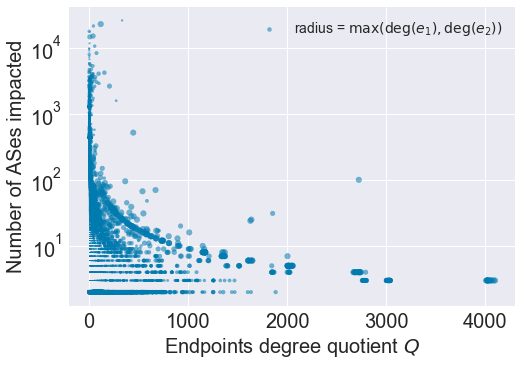

In [30]:
 crunch_deletion_impact("./simulation/data/full-impact-spo-GRP-chosen.csv");

       endpoint1  endpoint2  degree1  degree2  impact
0          34224      50039     1745       75       2
1          36351     269546     2829       35       2
2           1103      42676     1354       45       2
3          60501     198224     4472        6       2
4          56911      61568      109     3816       2
...          ...        ...      ...      ...     ...
42212      20562      41412      810       68       2
42213      61595     196925     1252      444       2
42214      31133      49730     1046      425     426
42215       8468      34309      889      195       2
42216     262541     262612        3     1238       2

[42217 rows x 5 columns]
Average impact: 35.778 	 Median impact: 2.000 	 Maximum impact: 25757 	 Standard deviation: 340.901


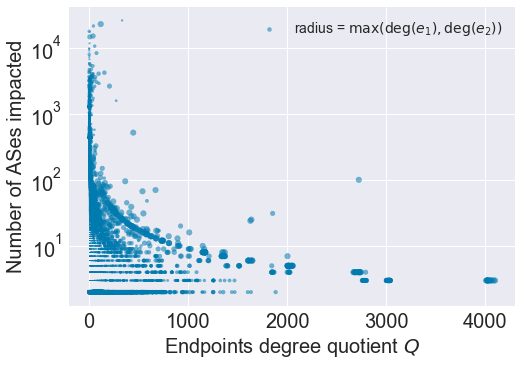

In [31]:
impact_spo_GRP_chosen = crunch_deletion_impact("./simulation/data/full-impact-spo-GRP-chosen.csv")
save_svg("edg_deg_chosen")

      endpoint1  endpoint2  degree1  degree2  impact
0         56665      44927     2229      475       2
1        197002      56605        3        2       3
2          6903      51011      427      432       2
3         41722      50952      783       12       2
4         20847      58299      139      218       2
...         ...        ...      ...      ...     ...
2995        174     395474     6041        3       4
2996     133815       4739       86      683       2
2997     138068     138840       31       61       2
2998        174      47927     6040       28      29
2999      11284      48467      462      435       2

[3000 rows x 5 columns]
Average impact: 88.012 	 Median impact: 2.000 	 Maximum impact: 27938 	 Standard deviation: 946.966


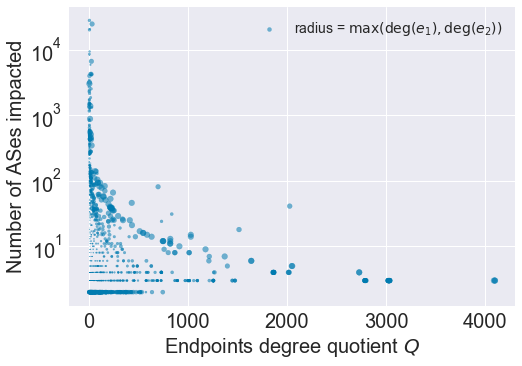

In [32]:
impact_spo_GRP_3000 = crunch_deletion_impact("./simulation/data/full-impact-spo-GRP-3000.csv")

30


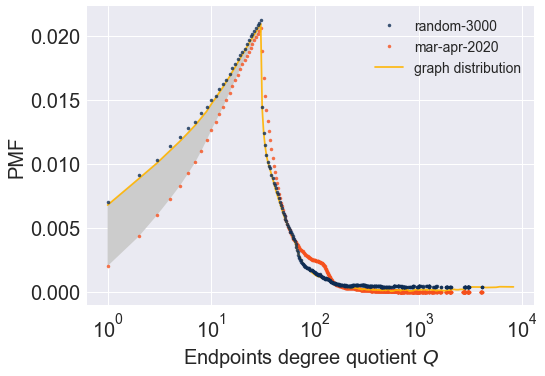

In [46]:
endpt_impact_random_distr = np.unique(np.around(impact_spo_GRP_3000[0][:,0]), return_counts=True)
endpt_impact_deg_distr = np.unique(np.around(impact_spo_GRP_chosen[0][:,0]), return_counts=True)
plt.plot(endpt_impact_random_distr[0], moving_average(endpt_impact_random_distr[1], 30) / moving_average(endpt_impact_random_distr[1], 30).sum(), '.', color="#0D2C54", alpha=.8, label="random-3000", zorder=10)
plt.plot(endpt_impact_deg_distr[0], moving_average(endpt_impact_deg_distr[1], 30) / moving_average(endpt_impact_deg_distr[1], 30).sum(), '.', color="#F6511D", alpha=.8, label="mar-apr-2020")
plt.plot(endpt_degree_distr[0], moving_average(endpt_degree_distr[1], 30) / moving_average(endpt_degree_distr[1], 30).sum(), '-', color="#FFB400", alpha=.9, label="graph distribution")

# Draw shaded area
peak_idx = np.argmax(moving_average(endpt_impact_random_distr[1], 30))+1
print(peak_idx)
plt.fill(
    np.concatenate([endpt_impact_deg_distr[0][:peak_idx], endpt_degree_distr[0][peak_idx::-1]]),
    np.concatenate([(moving_average(endpt_impact_deg_distr[1], 30) / moving_average(endpt_impact_deg_distr[1], 30).sum())[:peak_idx], 
                    (moving_average(endpt_degree_distr[1], 30) / moving_average(endpt_degree_distr[1], 30).sum())[peak_idx::-1]
                   ]),
    "#cccccc"
)

#plt.title("Endpoint degrees quotien distribution")
plt.xlabel(r"Endpoints degree quotient $Q$")
plt.ylabel("PMF")
plt.xscale("log")
#plt.yscale("log")
plt.legend();
#save_svg("edg_deg_diff")

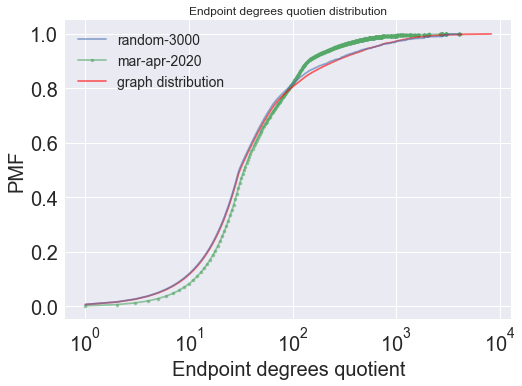

In [43]:
endpt_impact_random_distr = np.unique(np.around(impact_spo_GRP_3000[0][:,0]), return_counts=True)
endpt_impact_deg_distr = np.unique(np.around(impact_spo_GRP_chosen[0][:,0]), return_counts=True)
plt.plot(endpt_impact_random_distr[0], np.cumsum(moving_average(endpt_impact_random_distr[1], 30) / moving_average(endpt_impact_random_distr[1], 30).sum()), '-', alpha=.6, label="random-3000", zorder=10)
plt.plot(endpt_impact_deg_distr[0], np.cumsum(moving_average(endpt_impact_deg_distr[1], 30) / moving_average(endpt_impact_deg_distr[1], 30).sum()), '.-', alpha=.6, label="mar-apr-2020")
plt.plot(endpt_degree_distr[0], np.cumsum(moving_average(endpt_degree_distr[1], 30) / moving_average(endpt_degree_distr[1], 30).sum()), '-', color="red", alpha=.6, label="graph distribution")
plt.title("Endpoint degrees quotien distribution")
plt.xlabel("Endpoint degrees quotient")
plt.ylabel("PMF")
plt.xscale("log")
#plt.yscale("log")
plt.legend();

In [ ]:
# Sanity check
(moving_average(endpt_impact_random_distr[1], 30) / moving_average(endpt_impact_random_distr[1], 30).sum()).sum(),(moving_average(endpt_impact_deg_distr[1], 30) / moving_average(endpt_impact_deg_distr[1], 30).sum()).sum(),(moving_average(endpt_degree_distr[1], 30) / moving_average(endpt_degree_distr[1], 30).sum()).sum()

In [ ]:
impact_o_GRP_3000 = crunch_deletion_impact("./simulation/data/full-impact-o-GRP-3000.csv")

In [ ]:
impact_GRP_3000 = crunch_deletion_impact("./simulation/data/full-impact-GRP-3000.csv")

In [ ]:
impact_4000 = crunch_deletion_impact("./simulation/data/full-impact-4000.csv")

In [ ]:
impact_GR_3000 = crunch_deletion_impact("./simulation/data/full-impact-GR-3000.csv")

In [ ]:
plt.figure(figsize=(8, 6))
plt.title("Nodes updated by degree quotient")
plt.scatter(impact_4000[0][:,0], impact_4000[0][:,1], impact_4000[1] * .002, alpha=.2, label="Non GR")
plt.scatter(impact_GR_3000[0][:,0], impact_GR_3000[0][:,1], impact_GR_3000[1] * .002, alpha=.2, label="GR")
plt.scatter(impact_spo_GRP_3000[0][:,0], impact_spo_GRP_3000[0][:,1], impact_spo_GRP_3000[1] * .02, alpha=.2, label="GRP")
plt.yscale("log")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()
plt.ylabel("AS updated")
plt.xlabel("Quotient between degrees of endpoints");
#plt.savefig("./figs/" + dataset_name + "-deg_quotient.svg")

#### Invalidation hop distance

In [ ]:
def explode_measures(pands):
    res = []
    for idx, row in enumerate(pands["measure"]):
        for n in row.split("-")[:-1]:
            res.append([idx, n])
    return np.array(res)

In [ ]:
def get_measures_by_event(impact_filename):
    del_impact = import_impact_measurements(impact_filename)
    raw_measures = explode_measures(del_impact)
    measures = np.concatenate([raw_measures[:,0:1], np.vectorize(lambda x: x.split("@")[0])(raw_measures[:,1])[..., np.newaxis], np.vectorize(lambda x: x.split("@")[1])(raw_measures[:,1])[...,np.newaxis]], axis=1)
    measures = measures.astype(int)
    print(measures[:10,...])
    measures_by_event = [x[:,1:] for x in np.split(measures, np.unique(measures[:,0], return_index=True)[1])[1:]]
    
    # Sanity check:
    # there are always exactly 2 nodes at distance zero for each event
    assert (apply_func_by_event(measures_by_event, lambda x: (x[:,1] == 0).sum()) != 2).sum() == 0
    
    return measures_by_event

In [ ]:
def apply_func_by_event(ms, operator, combinator=None, zero=0):
    if combinator == None:
        result = []
        for x in ms:
            result.append(operator(x))
        return np.array(result)
    else:
        acc = zero
        for x in ms:
            acc = combinator(acc, operator(x))
        return acc

I try with:
  - `measures_spo_GRP_3000`:   3000 random deletions
  - `measures_spo_GRP_chosen`: the edges that when offline between March and April 2020, as measured by CAIDA

In [ ]:
measures_spo_GRP_3000 = get_measures_by_event("./simulation/data/full-impact-spo-GRP-3000.csv")
measures_spo_GRP_chosen = get_measures_by_event("./simulation/data/full-impact-spo-GRP-chosen.csv")

In [ ]:
def mean_distance(meas_by_evt):
    acc_res = apply_func_by_event(meas_by_evt, lambda x: (x[:,1].sum(), x[:,1].shape[0]), lambda acc, r: (acc[0]+r[0], acc[1]+r[1]), (0, 0))
    mean = float(acc_res[0]) / acc_res[1]
    return mean

In [ ]:
def max_distance(meas_by_evt):
    max = apply_func_by_event(meas_by_evt, lambda x: x[:,1].max(), lambda acc, r: acc if r < acc else r)
    return max

In [ ]:
# Update distribution (# of ASes)
def draw_update_distribution(meas_by_evt):
    sorted_update_size = np.sort(apply_func_by_event(meas_by_evt, lambda x: x.shape[0]))
    update_distr = np.unique(sorted_update_size, return_counts=True)
    plt.scatter(update_distr[0], update_distr[1]/update_distr[1].sum().astype(float))
    plt.title("Update impact distribution")
    plt.xscale("log")

In [ ]:
# Update hop-distance distribution
def draw_hop_distance_distribution(meas_by_evt, data_name="", color_param=None):
    distance_distr = np.unique(np.sort(np.concatenate(apply_func_by_event(meas_by_evt, lambda x: x[:,1]))), return_counts=True)
    plt.plot(distance_distr[0], distance_distr[1] / distance_distr[1].sum().astype(float), "--o", color=color_param, alpha=.9, label=data_name)

In [ ]:
top_level_as = np.array([   174,   3356,   7018,   3549,   1299,   3257,    209,   6461,
         2914,   6939,    701,  12389,   9498,   8220,   9002,  46887,
         4826,   3216,  13101,   6830,   2828,   4755,  20485,   6453,
        16735,   3320,   3491,  22773,  31133,   4766,   6762,  10429,
        12741,   5588,   8359,   7029,   4637,  20115,   1221,   3786,
        32787,   8708,  20473,   7717,   9318,   1239,  54004, 201054,
         4230,   7474,  50607,  20764,   3326, 201053,  55410,   9049,
        10796,   5617,   4809,   7713,   8218,    577,  33491,  12874])

In [ ]:
caida_top_64 = np.array([3356,1299,174,3257,2914,6762,6939,6453,3491,6461,1273,3549,9002,5511,4637,12956,7473,209,12389,3320,701,7018,7922,20485,3216,16735,9498,31133,6830,20764,2828,52320,15412,1239,8359,286,43531,58453,10429,262589,28917,37468,4809,4755,7738,33891,31500,41095,4766,8220,4826,11537,7843,18881,29076,34800,46887,4230,5483,20804,4134,8167,267613,7029])

In [ ]:
def top_as_updated(meas_by_evt):
    top_level_update = apply_func_by_event(meas_by_evt, lambda x: np.in1d(x[:,0], caida_top_64).sum() > 0).sum()
    return float(top_level_update) / apply_func_by_event(meas_by_evt, lambda x: 1, lambda acc, r: acc+r)

def top_as_incident_edges(meas_by_evt):
    top_level_orig = apply_func_by_event(meas_by_evt, lambda x: (x[np.in1d(x[:,0], caida_top_64), 1] == 0).sum() > 0).sum()
    return float(top_level_orig) / apply_func_by_event(meas_by_evt, lambda x: 1, lambda acc, r: acc+r)

#print("~%.2f%% of events involve the update of a top-level AS (64 most important ones according to ASRank)" % ())
#print("~%.2f%% of events involve the deletion of a link adjacent to a top-level AS (64 most important ones according to ASRank)" % ()

In [ ]:
draw_hop_distance_distribution(measures_spo_GRP_3000, "random-3000", "#C63508"), draw_hop_distance_distribution(measures_spo_GRP_chosen, "mar-apr-2020", "#005275")
plt.xlabel("Hop distance from broken link")
plt.ylabel("PMF")
#plt.title("PMF of hop distance")
plt.legend();
save_svg("hop_dist_pmf")

In [ ]:
print(tabulate([
    ["Mean hop-dist", "%.2f" % mean_distance(measures_spo_GRP_3000), "%.2f" % mean_distance(measures_spo_GRP_chosen)],
    ["Max hop-dist", max_distance(measures_spo_GRP_3000), max_distance(measures_spo_GRP_chosen)],
    ["Updates of 64 top-level AS (ASRank)", ("%.2f%%" % (100 * top_as_updated(measures_spo_GRP_3000))), ("%.2f%%" % (100 * top_as_updated(measures_spo_GRP_chosen)))],
    ["Deletion of edges incident on top-level AS", ("%.2f%%" % (100 * top_as_incident_edges(measures_spo_GRP_3000))), ("%.2f%%" % (100 * top_as_incident_edges(measures_spo_GRP_chosen)))]
], headers=["Metric", "random-3000", "mar-apr-2020"]))


**Observations**:
  1. top-level ASes are _almost never_ updated if their are not one of the endpoints of the deleted link. This is **positive** since that means the information about the impact does not reach the top-tier ASes
  2. the number of times top ASes are updated is lower in real data than for random simulation. This corresponds to the intuition that **links incident on top-level ASes are less likely to break** (more stable)
  3. The previous observation is consistent with the PDF of the hop-distance: real data from CAIDA have **more abundant deletions that just involve the endpoints** of the deleted edges

In [195]:
def plot_impact_with_updates(impact_param, measures_param):
    # Calculate impact of updates (only)
    update_spo_chosen_by_evt = apply_func_by_event(measures_param, lambda x: x.shape[0])
    
    #plt.scatter(impact_param[0][:,0], impact_param[0][:,1], impact_param[1] * .003, color="", edgecolor="#F6511D", label="impact")
    #plt.scatter(impact_param[0][:,0], update_spo_chosen_by_evt, impact_param[1] * .003, color="", edgecolor="#0D2C5499", label="update")
    plt.scatter(impact_param[0][:,0], impact_param[0][:,1], impact_param[1] * .007, color="#F6511DCC", label="impact")
    plt.scatter(impact_param[0][:,0], update_spo_chosen_by_evt, impact_param[1] * .007, color="#0D2C54BB", label="updates")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"Quotient between endpoints degree $Q$")
    plt.ylabel("Number of ASes")
    plt.legend();

In [196]:
np.average(apply_func_by_event(measures_spo_GRP_3000, lambda x: x.shape[0]))

26.106

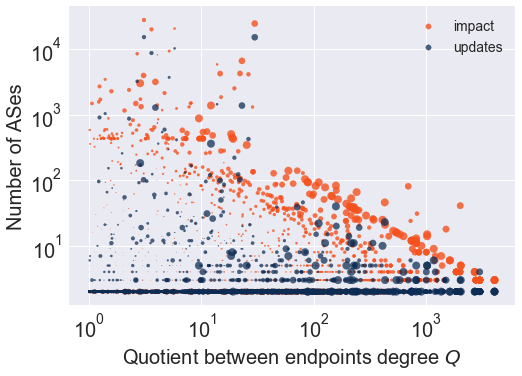

In [198]:
plot_impact_with_updates(impact_spo_GRP_3000, measures_spo_GRP_3000)
save_svg("impact_updates_3000")

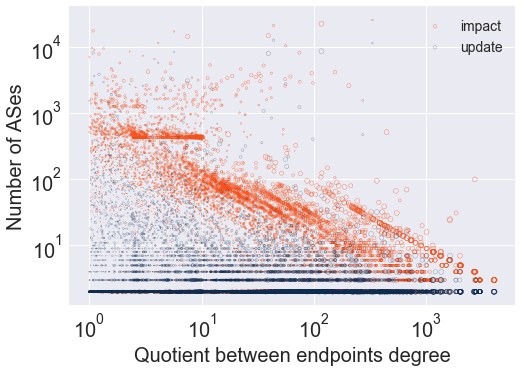

In [122]:
plot_impact_with_updates(impact_spo_GRP_chosen, measures_spo_GRP_chosen)

In [211]:
impact_spo_GRP_chosen[1]

array([[1745],
       [2829],
       [1354],
       ...,
       [1046],
       [ 889],
       [1238]], dtype=int64)

## Landmarks level used before/after deletions

In [4]:
def import_landmarks_level(filename):
    df = pd.read_csv(filename, names=[
        "baseline_before", 
        "baseline_types_before",
        "audited_level_before",
        "audited_path_before",
        "baseline_after",
        "baseline_types_after",
        "audited_level_after",
        "audited_path_after"])
    return df

In [5]:
landmarks_level_pandas = import_landmarks_level("./simulation/data/landmarks-level-deletion-spo-GRP-3000.csv")

In [6]:
landmarks_level_pandas

,baseline_before,baseline_types_before,audited_level_before,audited_path_before,baseline_after,baseline_types_after,audited_level_after,audited_path_after
0,2,0>,2,61595>52925>1251>61832>263327>,3,0>-1>,2,61595>52925>1251>61832>263327>
1,2,0>,2,13238>42708>13101>13249>,3,0>-1>,2,13238>42708>13101>13249>
2,2,0>,1,50763>8943>1299>31042>,3,0>-1>,1,50763>8943>1299>31042>
3,2,0>,1,63927>1299>48303>,3,0>-1>,1,63927>1299>48303>
4,2,0>,1,39642>13101>35753>15605>,3,0>-1>,1,39642>13101>35753>15605>
...,...,...,...,...,...,...,...,...
2995,2,0>,1,268668>265937>264144>12956>52925>52863>,4,0>-1>-1>,1,268668>265937>264144>12956>52925>52863>
2996,2,0>,1,44347>31133>1299>48822>,3,0>-1>,1,44347>31133>1299>48822>
2997,4,-1>-1>-1>,0,6939>57723>,4,-1>-1>-1>,2,6939>1299>3356>57723>
2998,2,0>,0,28186>50352>,4,1>1>-1>,2,28186>52925>3223>50352>


In [7]:
landmarks_level = landmarks_level_pandas.to_numpy()

# Measure hops and not number of nodes
landmarks_level[:,0] -= 1
landmarks_level[:,4] -= 1

In [8]:
count_path_len = np.vectorize(lambda x: len(x.split(">")) - 2)

In [9]:
landmarks_benchmark = np.stack((
    (count_path_len(landmarks_level[:,7]) / count_path_len(landmarks_level[:,3]).astype(float)).astype(int),
    landmarks_level[:,2],
    landmarks_level[:,6]), axis=1)

In [10]:
landmarks_benchmark = landmarks_benchmark[np.argsort(landmarks_benchmark[:,0]),:].astype(int)

In [11]:
landmarks_benchmark

array([[1, 2, 2],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [5, 0, 2],
       [6, 1, 2],
       [6, 1, 2]])

In [12]:
lev_distr_before = np.unique(landmarks_benchmark[:,1], return_counts=True)
lev_distr_after = np.unique(landmarks_benchmark[:,2], return_counts=True)

In [13]:
landmarks_by_increase = np.split(landmarks_benchmark, np.unique(landmarks_benchmark[:,0], return_index=True)[1])[1:]

In [14]:
land_counts_by_increase = [(x[0,0], np.unique(x[:,1], return_counts=True), np.unique(x[:,2], return_counts=True)) for x in landmarks_by_increase]

In [15]:
land_counts_by_increase

[(1,
  (array([1, 2]), array([1937,  610], dtype=int64)),
  (array([1, 2]), array([1937,  610], dtype=int64))),
 (2,
  (array([0, 1]), array([51, 48], dtype=int64)),
  (array([0, 1, 2]), array([43, 54,  2], dtype=int64))),
 (3,
  (array([0, 1, 2]), array([101, 109,   7], dtype=int64)),
  (array([0, 1, 2]), array([  3,  19, 195], dtype=int64))),
 (4,
  (array([0, 1, 2]), array([48, 64,  8], dtype=int64)),
  (array([1, 2]), array([ 11, 109], dtype=int64))),
 (5,
  (array([0, 1]), array([6, 9], dtype=int64)),
  (array([1, 2]), array([ 2, 13], dtype=int64))),
 (6,
  (array([1]), array([2], dtype=int64)),
  (array([2]), array([2], dtype=int64)))]

In [16]:
3000-(1937+610)

453

In [17]:
print("rho > 1 and before using level-0 : %.3f%%" % ((51+101+48+6+2)/453*100))

rho > 1 and before using level-0 : 45.916%


In [18]:
print("rho > 1 and after using level-2 : %.3f%%" % ((2+195+109+13+2)/453*100))

rho > 1 and after using level-2 : 70.861%


In [19]:
land_counts_before = {}
land_counts_after = {}

rel_widths = []

for x in land_counts_by_increase:
    before_bins = []
    after_bins = []
    for i in range(0, 3):
        before_idx = np.where(x[1][0] == i)[0]
        if not before_idx.size == 0:
            before_bins.append(x[1][1][before_idx[0]])
        else:
            before_bins.append(0)
        after_idx = np.where(x[2][0] == i)[0]
        if not after_idx.size == 0:
            after_bins.append(x[2][1][after_idx[0]])
        else:
            after_bins.append(0)
    land_counts_before[x[0]] = np.array(before_bins)
    land_counts_after[x[0]] = np.array(after_bins)
    
    rel_widths.append(land_counts_before[x[0]].sum())
    
    # Normalize dict entry
    land_counts_before[x[0]] = land_counts_before[x[0]] / land_counts_before[x[0]].sum()
    land_counts_after[x[0]] = land_counts_after[x[0]] / land_counts_after[x[0]].sum()

In [20]:
rel_widths = np.array(rel_widths)
rel_widths = rel_widths / rel_widths.min()

In [21]:
land_counts_before, land_counts_after, rel_widths

({1: array([0.        , 0.76050255, 0.23949745]),
  2: array([0.51515152, 0.48484848, 0.        ]),
  3: array([0.46543779, 0.50230415, 0.03225806]),
  4: array([0.4       , 0.53333333, 0.06666667]),
  5: array([0.4, 0.6, 0. ]),
  6: array([0., 1., 0.])},
 {1: array([0.        , 0.76050255, 0.23949745]),
  2: array([0.43434343, 0.54545455, 0.02020202]),
  3: array([0.01382488, 0.0875576 , 0.89861751]),
  4: array([0.        , 0.09166667, 0.90833333]),
  5: array([0.        , 0.13333333, 0.86666667]),
  6: array([0., 0., 1.])},
 array([1.2735e+03, 4.9500e+01, 1.0850e+02, 6.0000e+01, 7.5000e+00,
        1.0000e+00]))

In [22]:
path_increase_labels = 2*np.array(list(land_counts_before.keys()))
path_increase_labels

array([ 2,  4,  6,  8, 10, 12])

In [23]:
ld_values_before = list(land_counts_before.values())
ld_values_after = list(land_counts_after.values())
ld_values_before, ld_values_after

([array([0.        , 0.76050255, 0.23949745]),
  array([0.51515152, 0.48484848, 0.        ]),
  array([0.46543779, 0.50230415, 0.03225806]),
  array([0.4       , 0.53333333, 0.06666667]),
  array([0.4, 0.6, 0. ]),
  array([0., 1., 0.])],
 [array([0.        , 0.76050255, 0.23949745]),
  array([0.43434343, 0.54545455, 0.02020202]),
  array([0.01382488, 0.0875576 , 0.89861751]),
  array([0.        , 0.09166667, 0.90833333]),
  array([0.        , 0.13333333, 0.86666667]),
  array([0., 0., 1.])])

In [48]:
ldmarks_color = ["#005275", "#DF9C00", "#C63508"] #["#0D2C54", "#7FB800", "#C63508"]
ldmarks_alpha = [.7, .8, .9]
ldmarks_width = .15 * np.log(rel_widths) #.05
ldmarks_dist = .52 * ldmarks_width #.03
ldmarks_labels_before = [r"$\pi_{TZ}^1$, level-0", r"$\pi_{TZ}^1$, level-1", r"$\pi_{TZ}^1$, level-2"]
ldmarks_labels_after = [r"$\pi_{TZ}^2$, level-0", r"$\pi_{TZ}^2$, level-1", r"$\pi_{TZ}^2$, level-2"]

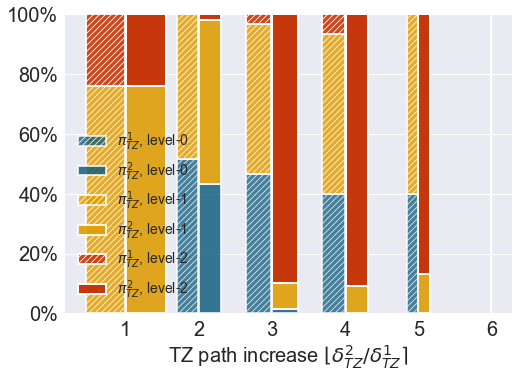

In [53]:
plt.bar(path_increase_labels-ldmarks_dist, [x[0] for x in ld_values_before], width=ldmarks_width, color=ldmarks_color[0], alpha=ldmarks_alpha[0], hatch="////", edgecolor="#ffffff00", linewidth=2, label=ldmarks_labels_before[0])
plt.bar(path_increase_labels+ldmarks_dist, [x[0] for x in ld_values_after], width=ldmarks_width, color=ldmarks_color[0], alpha=ldmarks_alpha[0] * 1.1, edgecolor="#ffffff00", linewidth=2, label=ldmarks_labels_after[0])
for path_inc in range(1, 3):
    plt.bar(path_increase_labels-ldmarks_dist, [x[path_inc] for x in ld_values_before], bottom=[np.cumsum(x)[path_inc-1] for x in ld_values_before], width=ldmarks_width, color=ldmarks_color[path_inc], alpha=ldmarks_alpha[path_inc], hatch="////", edgecolor="#ffffff00", linewidth=2, label=ldmarks_labels_before[path_inc])
    plt.bar(path_increase_labels+ldmarks_dist, [x[path_inc] for x in ld_values_after], bottom=[np.cumsum(x)[path_inc-1] for x in ld_values_after], width=ldmarks_width, color=ldmarks_color[path_inc], alpha=ldmarks_alpha[path_inc] * 1.1, edgecolor="#ffffff00", linewidth=2, label=ldmarks_labels_after[path_inc])

plt.xticks(path_increase_labels)
plt.gca().set_xticklabels((path_increase_labels / 2).astype(int))
plt.gca().set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xlabel(r"TZ path increase $\lfloor \delta_{TZ}^2 / \delta_{TZ}^1 \rceil$")
plt.legend()
save_svg("landmarks_levels_del")

## Link deletion stretch increase

File `full-deletion-stretch-2000.csv` was obtained restarting 3 times:
 - after 1383 links deleted
 - after 1687 links deleted

In [4]:
def import_stretch_increase(filename):
    df = pd.read_csv(filename, names=["baseline_before", "audited_before", "baseline_after", "audited_after"])
    return df

In [5]:
def crunch_stretch_increase(filename):
    pd_deletion_stretch = import_stretch_increase(filename)
    deletion_stretch = pd_deletion_stretch.to_numpy().astype(float)
    
    # Measure hops and not nodes
    deletion_stretch = deletion_stretch - 1
    
    stretch_before = deletion_stretch[:,1].astype(float) / deletion_stretch[:,0]
    stretch_after = deletion_stretch[:,3].astype(float) / deletion_stretch[:,2]
    
    bgp_better_idxs = stretch_before >= 1
    tz_better_idxs = stretch_before < 1
    
    # Put stretch_before < 1 samples in different arrays
    tz_better_deletions = deletion_stretch[tz_better_idxs,:]
    tz_better_stretch_before = stretch_before[tz_better_idxs]
    tz_better_stretch_after = stretch_after[tz_better_idxs]
    
    # Remove samples with stretch_before < 1
    deletion_stretch = deletion_stretch[bgp_better_idxs,:]
    stretch_before = stretch_before[bgp_better_idxs]
    stretch_after = stretch_after[bgp_better_idxs]
    
    plt.figure()
    plt.xlabel("Stretch before deletion")
    plt.ylabel("Stretch after deletion")
    plt.scatter(stretch_before, stretch_after, alpha=.4)
    plt.scatter(tz_better_stretch_before, tz_better_stretch_after, alpha=.4)
    
    rho_increase_idx = stretch_after / stretch_before > 1
    rho_decrease_idx = stretch_after / stretch_before <= 1
    plt.figure()
    plt.scatter(deletion_stretch[rho_increase_idx,1], (stretch_after / stretch_before)[rho_increase_idx], marker='s', color="#A52C07", alpha=.2, zorder=2)
    plt.scatter(deletion_stretch[rho_decrease_idx,1], (stretch_after / stretch_before)[rho_decrease_idx], marker='s', color="#005275", alpha=.2, zorder=2)
    #plt.scatter(tz_better_deletions[:,1], tz_better_stretch_after / tz_better_stretch_before, alpha=.3, zorder=2)
    plt.xlabel(r"Initial TZ length $\delta_{TZ}^1$")
    plt.ylabel(r"Stretch increase $\rho$")
    plt.yscale("log")
    plt.gca().set_yticks([1, .5, .1])
    plt.gca().set_yticklabels(["1", "0.5", "0.1"])
    plt.hlines(1, xmin=1, xmax=5, color="#DF9C00", zorder=1)
    save_svg("del_stretch_increase")
    return pd_deletion_stretch.to_numpy().astype(float)

In [91]:
def crunch_stretch_ratios(filename):
    pd_deletion_stretch = import_stretch_increase(filename)
    deletion_stretch = pd_deletion_stretch.to_numpy().astype(float)
    
    # Measure hops and not nodes
    deletion_stretch = deletion_stretch - 1
    
    bgp_increase = deletion_stretch[:,2].astype(float) / deletion_stretch[:,0]
    tz_increase = deletion_stretch[:,3].astype(float) / deletion_stretch[:,1]
    
    plt.figure()
    plt.xlabel("BGP increase")
    plt.ylabel("TZ increase")
    plt.scatter(bgp_increase, tz_increase, s=50, marker='s', alpha=.3)
    plt.plot(np.array([0,8]), np.array([0,8]))
    
    plt.figure()
    plt.scatter(deletion_stretch[:,2], (tz_increase / bgp_increase), marker='s', color="#A52C07", alpha=.2, zorder=2)
    #plt.scatter(deletion_stretch[:,1], (stretch_after / stretch_before)[rho_decrease_idx], marker='s', color="#005275", alpha=.2, zorder=2)
    #plt.scatter(tz_better_deletions[:,1], tz_better_stretch_after / tz_better_stretch_before, alpha=.3, zorder=2)
    plt.ylabel(r"TZ length increase $\delta_{TZ}^1$")
    plt.xlabel(r"BGP after path $\rho$")
    #plt.yscale("log")
    #plt.gca().set_yticks([1, .5, .1])
    #plt.gca().set_yticklabels(["1", "0.5", "0.1"])
    plt.hlines(1, xmin=1, xmax=5, color="#DF9C00", zorder=1)
    #save_svg("del_stretch_increase")
    
    sorted_by_bgp_after = deletion_stretch[np.argsort(deletion_stretch[:,2])]
    stats_by_bgp_after = np.split(sorted_by_bgp_after, np.unique(sorted_by_bgp_after[:,2], return_index=True)[1])[1:]
    
    tz_bgp_after = []
    for x in stats_by_bgp_after:
        x_sorted = x[np.argsort(x[:,3])]
        tz_bgp_after.append((x[0,2], np.unique(x_sorted[:,3], return_counts=True)))
    
    print(tz_bgp_after)
    
    return tz_bgp_after

[(2.0, (array([2., 3., 4., 5.]), array([291, 276,  86,   3], dtype=int64))), (3.0, (array([2., 3., 4., 5., 6.]), array([ 38, 120,  30,   6,   1], dtype=int64))), (4.0, (array([2., 3., 4., 5., 6., 7.]), array([17, 27, 21,  2,  2,  1], dtype=int64))), (5.0, (array([2., 3., 4., 5.]), array([ 7, 14,  7,  8], dtype=int64))), (6.0, (array([2., 3., 4., 8.]), array([ 6, 11,  5,  1], dtype=int64))), (7.0, (array([2., 3., 4., 5.]), array([6, 1, 2, 1], dtype=int64))), (8.0, (array([2., 3., 4., 5.]), array([1, 4, 2, 2], dtype=int64))), (9.0, (array([4.]), array([1], dtype=int64)))]


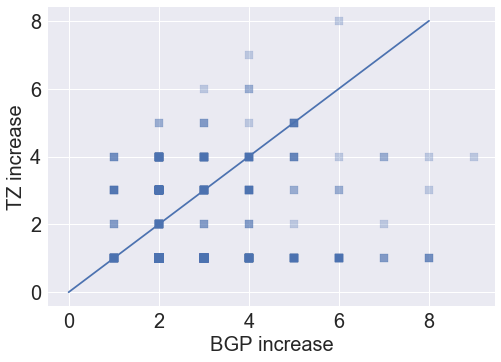

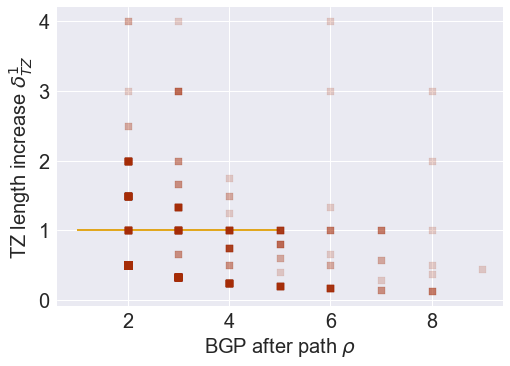

In [92]:
tz_bgp_after = crunch_stretch_ratios("./simulation/data/full-deletion-stretch-spo-GRP-1000.csv")

In [76]:
tz_bgp_after

[(2.0, (array([2., 3., 4., 5.]), array([291, 276,  86,   3], dtype=int64))),
 (3.0,
  (array([2., 3., 4., 5., 6.]),
   array([ 38, 120,  30,   6,   1], dtype=int64))),
 (4.0,
  (array([2., 3., 4., 5., 6., 7.]),
   array([17, 27, 21,  2,  2,  1], dtype=int64))),
 (5.0, (array([2., 3., 4., 5.]), array([ 7, 14,  7,  8], dtype=int64))),
 (6.0, (array([2., 3., 4., 8.]), array([ 6, 11,  5,  1], dtype=int64))),
 (7.0, (array([2., 3., 4., 5.]), array([6, 1, 2, 1], dtype=int64))),
 (8.0, (array([2., 3., 4., 5.]), array([1, 4, 2, 2], dtype=int64))),
 (9.0, (array([4.]), array([1], dtype=int64)))]

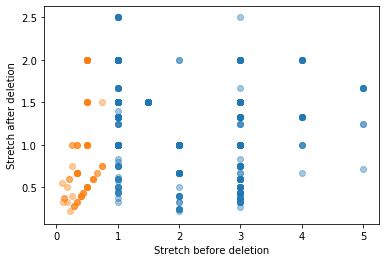

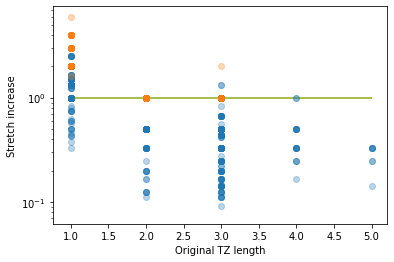

In [58]:
deletion_stretch = crunch_stretch_increase("./simulation/data/full-deletion-stretch-2000.csv")

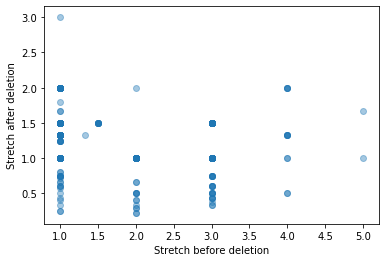

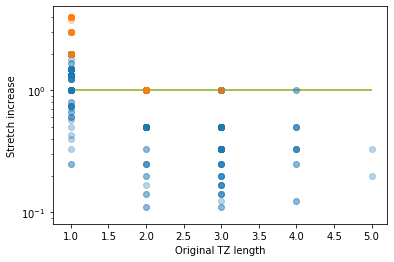

In [55]:
deletion_stretch_GR = crunch_stretch_increase("./simulation/data/full-deletion-stretch-GR-1000.csv")

In [44]:
deletion_stretch_GR[deletion_stretch_GR[:,0]>deletion_stretch_GR[:,1]]

array([[5., 3., 5., 3.],
       [6., 2., 6., 3.],
       [3., 2., 3., 4.],
       [4., 2., 4., 4.],
       [8., 2., 8., 5.],
       [5., 3., 5., 3.],
       [4., 2., 4., 4.],
       [6., 2., 5., 4.],
       [4., 2., 4., 4.],
       [3., 2., 3., 4.],
       [5., 2., 5., 4.],
       [4., 3., 4., 3.],
       [8., 3., 8., 3.],
       [6., 4., 6., 4.],
       [4., 2., 4., 3.],
       [7., 3., 7., 3.],
       [3., 2., 3., 3.],
       [3., 2., 3., 5.],
       [4., 3., 4., 3.],
       [4., 3., 4., 3.],
       [4., 3., 4., 3.],
       [3., 2., 3., 4.],
       [5., 2., 5., 5.],
       [5., 3., 5., 3.],
       [3., 2., 3., 5.],
       [7., 3., 7., 3.],
       [3., 2., 3., 5.],
       [7., 4., 7., 4.],
       [3., 2., 3., 3.],
       [4., 2., 4., 5.],
       [3., 2., 3., 4.],
       [7., 4., 7., 4.],
       [3., 2., 3., 5.],
       [3., 2., 3., 3.],
       [5., 4., 5., 4.],
       [4., 2., 4., 3.],
       [5., 3., 5., 3.],
       [3., 2., 3., 3.],
       [8., 2., 8., 4.],
       [4., 3., 4., 3.],


## Effect of multiple edge deletions on stretch

Starting from `cumulative-deletions-3x.1.csv` the first stretch measurement is performed **before** deleting any links

In [54]:
def import_cumulative_deletions(filename):
    df = pd.read_csv(filename, names=["baseline_stretch", "audited_stretch", "respects_no_valley"])
    return df

In [55]:
def stretch_statistics_by_round(round_data):
    return [(round_data[:,1]/round_data[:,0]).mean(), round_data[:,2].mean()]

In [56]:
def crunch_cumulative_deletions(filename):
    cumul_deletions = import_cumulative_deletions(filename)
    cumul_deletions = cumul_deletions.to_numpy()
    
    # Find lines that mark the beginning of a round (with the form [-round_num, -round_num, -round_num])
    cumul_by_round = np.split(cumul_deletions.astype(float), np.nonzero(np.sum(cumul_deletions, axis=1) < 1)[0])[1:]
    
    # Delete the markers
    cumul_by_round = [rd[1:] for rd in cumul_by_round]
    
    return np.array([stretch_statistics_by_round(r) for r in cumul_by_round]), cumul_by_round[0].shape[0]

In [57]:
# For each simulation, it stores ([[Stretch_by_round, With_valley_by_round] for rounds], samples_num_for_first_round)
cumulative_simulations = {
    "spo-GRP-6x.02": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRp-6x.02.csv"),
    "spo-GR-8x.02": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GR-8x.02.csv"),
    "spo-GR-8x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GR-8x.05.csv"),
    "spo-GRP-10x.025": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-land-spo-GRP-24x.025.csv"),
    "spo-GRP-12x0305-2000": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-12x0305-2000.csv"),
    "spo-GRP-12xChosen-2000-2": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-12xChosen-2000-2.csv"),
    "spo-GRP-12xChosen-2000": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-12xChosen-2000.csv"),
    "spo-GRP-12xChosen": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-12xChosen.csv"),
    "spo-GRP-7x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-spo-GRP-7x.05.csv"),
    "GRP-3x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GRP-3x.05-GCloud.csv"),
    "GR-4x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GR-4x.05-GCloud-(2).csv"),
    "GR-4x.10": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-GR-4x.10-GCloud.csv"),
    "8x.05" :crunch_cumulative_deletions("./simulation/data/cumulative-deletions-8x.05.csv"),
    "9x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(3).csv"),
    "10x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05-(2).csv"),
    "12x.05": crunch_cumulative_deletions("./simulation/data/cumulative-deletions-12x.05.csv")
}

In [58]:
cumulative_simulations["spo-GRP-12x0305-2000"]

(array([[1.06340368, 0.01014713],
        [1.05607016, 0.01477331],
        [1.05888067, 0.01267106],
        [1.05287079, 0.00707428],
        [1.06238804, 0.01064909],
        [1.06958962, 0.0126968 ],
        [1.06923068, 0.00967906],
        [1.06893168, 0.00967413],
        [1.06691702, 0.01270325],
        [1.07763355, 0.01265823],
        [1.06913693, 0.01218893],
        [1.07725699, 0.00866463],
        [1.06311416, 0.0116692 ]]), 1971)

In [59]:
def calculate_x_labels(deletion_proportion, number_of_epochs):
    full_edges_num = 466982
    return [100 * deletion_proportion * (math.pow(1 - deletion_proportion, k)-1) / float(-deletion_proportion) for k in range(0, number_of_epochs)]

In [60]:
def calculate_chosen_x_labels(deletions_number, number_of_epochs):
    full_edges_num = 466982
    return [100 * k * float(deletions_number) / (full_edges_num * number_of_epochs) for k in range(0, number_of_epochs)]

Text(0, 0.5, 'Average stretch')

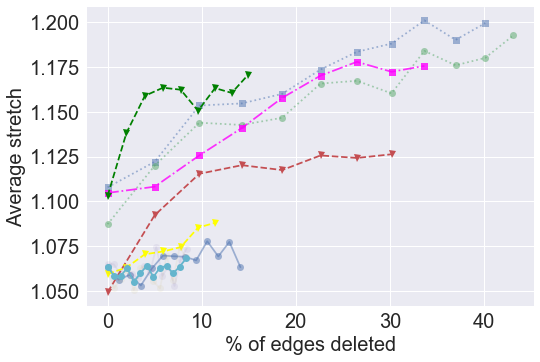

In [61]:
#plt.figure(figsize=(14, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(calculate_x_labels(.05, 11), cumulative_simulations["10x.05"][0][:,0], ':s', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 12), cumulative_simulations["12x.05"][0][:,0], ':o', alpha=.5, zorder=4)
#plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,0], '-.^', alpha=.7, zorder=10)
#plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,0], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 9), cumulative_simulations["spo-GR-8x.05"][0][:,0], '-.s', color="fuchsia", alpha=.8, zorder=10)
#plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,0], '--v', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.05, 8), cumulative_simulations["spo-GRP-7x.05"][0][:,0], '--v', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.02, 9), cumulative_simulations["spo-GR-8x.02"][0][:,0], '--v', color="green", alpha=1, zorder=15)
plt.plot(calculate_x_labels(.02, 7), cumulative_simulations["spo-GRP-6x.02"][0][:,0], '--v', color="yellow", alpha=1, zorder=15)
#Deletions: 42848 (total) - 622 (multiple conn. components) = 42226
plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen-2000"][0][:,0], '-o', alpha=.1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 13), cumulative_simulations["spo-GRP-12xChosen-2000-2"][0][:,0], '-o', alpha=.1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 13), (cumulative_simulations["spo-GRP-12xChosen-2000"][0][:-1,0]+cumulative_simulations["spo-GRP-12xChosen-2000-2"][0][:,0])/2., '-o', alpha=1, zorder=20)
#Deletions: 72631 (total) - 1240 (multiple conn. components) = 71391
plt.plot(calculate_chosen_x_labels(71391, 13), cumulative_simulations["spo-GRP-12x0305-2000"][0][:,0], '-o', alpha=.5, zorder=10)
plt.xlabel("% of edges deleted")
plt.ylabel("Average stretch")

In [62]:
def to_relative_stretch_increase(simulation_param):
    return (simulation_param / float(simulation_param[0]) - 1) * 100

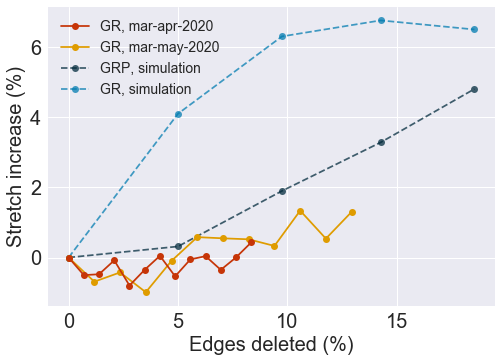

In [65]:
#plt.figure(figsize=(14, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.plot(calculate_x_labels(.05, 5), to_relative_stretch_increase(cumulative_simulations["10x.05"][0][:5,0]), ':s', alpha=.5, zorder=4)
#plt.plot(calculate_x_labels(.05, 5), to_relative_stretch_increase(cumulative_simulations["12x.05"][0][:5,0]), ':o', alpha=.5, zorder=4)

#plt.plot(calculate_x_labels(.02, 9), to_relative_stretch_increase(cumulative_simulations["spo-GR-8x.02"][0][:,0]), '--v', color="green", alpha=1, zorder=15)
#plt.plot(calculate_x_labels(.02, 7), to_relative_stretch_increase(cumulative_simulations["spo-GRP-6x.02"][0][:,0]), '--v', color="yellow", alpha=1, zorder=15)

#Deletions: 42848 (total) - 622 (multiple conn. components) = 42226
plt.plot(calculate_chosen_x_labels(42226, 13), to_relative_stretch_increase((cumulative_simulations["spo-GRP-12xChosen-2000"][0][:-1,0]+cumulative_simulations["spo-GRP-12xChosen-2000-2"][0][:,0])/2.), 'o-', color="#C63508", zorder=20, label="GR, mar-apr-2020")
#Deletions: 72631 (total) - 1240 (multiple conn. components) = 71391
plt.plot(calculate_chosen_x_labels(71391, 13)[:-1], to_relative_stretch_increase(cumulative_simulations["spo-GRP-12x0305-2000"][0][:,0])[:-1], 'o-', color="#DF9C00", zorder=19, label="GR, mar-may-2020")
plt.plot(calculate_x_labels(.05, 5), to_relative_stretch_increase(cumulative_simulations["spo-GR-8x.05"][0][:5,0]), 'o--', color="#00293BBB", zorder=10, label="GRP, simulation")
plt.plot(calculate_x_labels(.05, 5), to_relative_stretch_increase(cumulative_simulations["spo-GRP-7x.05"][0][:5,0]), 'o--', color="#007BB0BB", zorder=15, label="GR, simulation")
plt.xlabel("Edges deleted (%)")
plt.ylabel("Stretch increase (%)")
plt.legend()
save_svg("stretch_evo")

In [44]:
calculate_x_labels(.020, 10)

[-0.0,
 2.0000000000000018,
 3.960000000000008,
 5.880800000000008,
 7.763184000000011,
 9.607920320000007,
 11.415761913600008,
 13.187446675328006,
 14.923697741821451,
 16.62522378698502]

Text(0, 0.5, 'Average stretch')

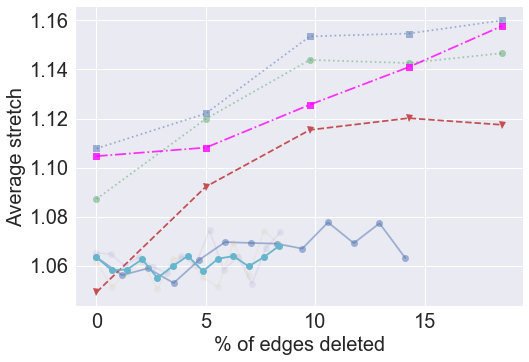

In [38]:
#plt.figure(figsize=(14, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["10x.05"][0][:5,0], ':s', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["12x.05"][0][:5,0], ':o', alpha=.5, zorder=4)
#plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,0], '-.^', alpha=.7, zorder=10)
#plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,0], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["spo-GR-8x.05"][0][:5,0], '-.s', color="fuchsia", alpha=.8, zorder=10)
#plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,0], '--v', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["spo-GRP-7x.05"][0][:5,0], '--v', alpha=1, zorder=15)
#Deletions: 42848 (total) - 622 (multiple conn. components) = 42226
plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen-2000"][0][:,0], '-o', alpha=.1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 13), cumulative_simulations["spo-GRP-12xChosen-2000-2"][0][:,0], '-o', alpha=.1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 13), (cumulative_simulations["spo-GRP-12xChosen-2000"][0][:-1,0]+cumulative_simulations["spo-GRP-12xChosen-2000-2"][0][:,0])/2., '-o', alpha=1, zorder=20)
#Deletions: 72631 (total) - 1240 (multiple conn. components) = 71391
plt.plot(calculate_chosen_x_labels(71391, 13), cumulative_simulations["spo-GRP-12x0305-2000"][0][:,0], '-o', alpha=.5, zorder=10)
plt.xlabel("% of edges deleted")
plt.ylabel("Average stretch")

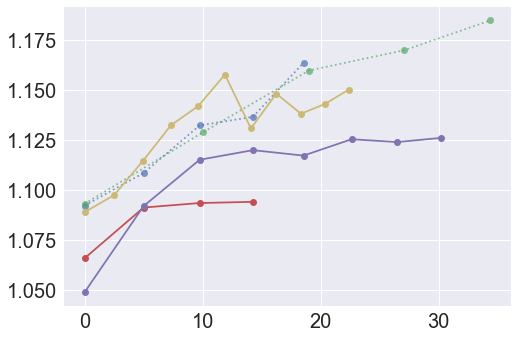

In [351]:
#plt.plot(calculate_x_labels(.05, 11), cumulative_simulations["10x.05"][0][:,0], ':s', alpha=.5, zorder=4)
#plt.plot(calculate_x_labels(.05, 12), cumulative_simulations["12x.05"][0][:,0], ':o', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,0], 'o:', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,0], 'o:', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,0], '-o', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.05, 8), cumulative_simulations["spo-GRP-7x.05"][0][:,0], '-o', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.025, 11), cumulative_simulations["spo-GRP-10x.025"][0][:,0], '-o', alpha=1, zorder=15)

Text(0, 0.5, 'Fraction of paths with valleys')

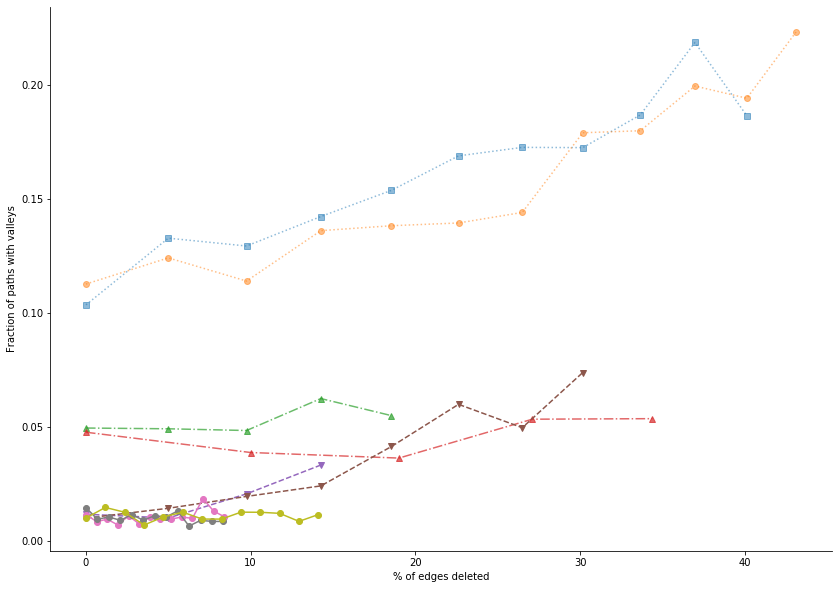

In [178]:
plt.figure(figsize=(14, 10))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(calculate_x_labels(.05, 11), cumulative_simulations["10x.05"][0][:,1], ':s', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 12), cumulative_simulations["12x.05"][0][:,1], ':o', alpha=.5, zorder=4)
plt.plot(calculate_x_labels(.05, 5), cumulative_simulations["GR-4x.05"][0][:,1], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.1, 5), cumulative_simulations["GR-4x.10"][0][:,1], '-.^', alpha=.7, zorder=10)
plt.plot(calculate_x_labels(.05, 4), cumulative_simulations["GRP-3x.05"][0][:,1], '--v', alpha=1, zorder=15)
plt.plot(calculate_x_labels(.05, 8), cumulative_simulations["spo-GRP-7x.05"][0][:,1], '--v', alpha=1, zorder=15)
#plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen"][0][:,1], '-o', alpha=1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 14), cumulative_simulations["spo-GRP-12xChosen-2000"][0][:,1], '-o', alpha=1, zorder=20)
plt.plot(calculate_chosen_x_labels(42226, 13), cumulative_simulations["spo-GRP-12xChosen-2000-2"][0][:,1], '-o', alpha=1, zorder=20)
plt.plot(calculate_chosen_x_labels(71391, 13), cumulative_simulations["spo-GRP-12x0305-2000"][0][:,1], '-o', alpha=1, zorder=20)
plt.xlabel("% of edges deleted")
plt.ylabel("Fraction of paths with valleys")